# Мастерская 2 (DS20+). Решение задачи мэтчинга для "склада товаров"

Входные данные:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- `target.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- `validation_answer.csv` - правильные ответы к предыдущему файлу.


Задачи:
- разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base`

- оценить качество алгоритма по метрике **accuracy@5**

- *деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

Основная задача матчинга будет решаться алгоритмом приближённого поиска ближайших соседей с помощью библиотеки `FAISS`.

## Подготовка среды

### Импорт библиотек

In [1]:
!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np
import faiss
# from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [3]:
# библиотеки, необходимые для загрузки из облака архива с данными
# и его распаковки в текущую файловую систему
import zipfile
import requests
from urllib.parse import urlencode
import os.path

In [4]:
pip install catboost

In [94]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import roc_auc_score
from joblib import dump, load

### Загрузка данных из облака

Загрузим архив с данными из облака yandex.drive и распакуем файлы на виртуальный диск Colab

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
zip_path = '/content/drive/MyDrive/data.zip'
#zip_path = '/content/data.zip'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [7]:
if not os.path.exists(zip_path):
  download_response = requests.get(download_url)
  with open(zip_path, 'wb') as f:
    f.write(download_response.content)

In [8]:
# Распаковка zip-архива
if not os.path.exists('/content/base.csv'):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

### Чтение датасетов

Подготовим словарь для корректной загрузки типов данных. По умолчанию загружается float64, мы используем float32.

In [9]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'

dict_train = dict_base.copy()
dict_train['Target'] = 'str'

Загрузка основного датасета `base.csv`

In [10]:
df_base = pd.read_csv("/content/base.csv", index_col=0, dtype=dict_base)
df_base.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
105939-base,-77.987846,15.074545,-45.659576,-148.266968,98.016617,-114.873566,-604.358765,-17.662687,130.678040,206.392761,...,-65.667610,42.516079,-214.034515,-9.925874,65.858620,1.777658,15.903370,107.861488,-1074.464844,-88.011780
187743-base,-114.331108,11.621432,-56.707249,-136.842667,126.705406,-66.646072,-644.492310,31.529060,125.389427,46.083138,...,-86.769333,14.074669,-102.944427,102.635681,67.742439,14.114362,-7.668129,127.330765,-781.714294,-100.219986
2062023-base,-77.375755,5.503790,-46.945145,-179.129364,143.984192,-69.301605,-73.905800,41.278702,117.060242,77.615967,...,-111.562698,70.999405,-131.287689,106.451485,67.241104,109.534744,63.569424,109.886093,-103.763184,-62.235680
2531005-base,-85.798134,13.568428,-53.606682,-149.432907,138.078217,-72.410309,26.414146,44.749210,125.561195,143.459885,...,-24.284641,38.535736,-199.945633,-21.533007,68.202240,11.909060,112.319519,122.295074,-1074.464844,-46.379013
2968252-base,-80.585365,11.575529,-77.083382,-114.335922,118.499420,-89.317375,-320.681244,118.346764,113.141006,169.126007,...,-59.781273,-22.050457,-142.392807,-51.620872,66.381279,93.367752,54.914684,129.004654,-854.289856,-75.077881


In [11]:
df_base.shape

(2918139, 72)

In [12]:
df_base[['0','32','71']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   32      float32
 2   71      float32
dtypes: float32(3)
memory usage: 55.7+ MB


Загрузка датасета с таргетами `train.csv`

In [13]:
df_train = pd.read_csv("/content/train.csv", index_col=0, dtype=dict_train)
df_train.sample()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
96577-query,-24.637184,13.782,-69.065002,-184.424301,86.947678,-92.392204,-296.958221,-93.549988,115.723213,200.179565,...,32.991913,-175.481934,127.973976,68.945702,5.008123,126.304756,120.89225,-1141.939087,-135.402054,2220645-base


In [14]:
df_train.shape

(100000, 73)

Загрузка датасета с заданием `validation.csv`

In [15]:
df_validation = pd.read_csv("/content/validation.csv", index_col=0, dtype=dict_train)
df_validation.sample()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
103683-query,-36.183163,9.597116,-25.092632,-122.876801,80.975372,-72.6147,-759.626038,-6.267447,114.399857,95.768143,...,-131.931473,30.858883,-137.749451,78.763222,69.444885,-46.221863,36.583916,100.895378,-734.083069,-79.720322


In [105]:
#df_validation.iloc[0, :].tolist()

In [16]:
df_validation.shape

(100000, 72)

Загрузка датасета с ответами `validation_answer.csv`

In [17]:
df_validation_answer = pd.read_csv("/content/validation_answer.csv", index_col=0, dtype=dict_train)
df_validation_answer.sample()

,Expected
Id,
120861-query,100447-base


In [18]:
df_validation_answer.shape

(100000, 1)

In [19]:
df_validation_answer_all = df_validation.join(df_validation_answer)

In [20]:
df_validation_answer_all.sample()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Expected
Id,,,,,,,,,,,,,,,,,,,,,
180940-query,-79.009872,15.107468,-68.366463,-125.990524,101.606873,-35.695995,107.283272,86.823219,128.66214,138.655457,...,10.498564,-142.712677,-63.714378,65.9142,-32.778316,109.305725,88.790482,-969.088623,-8.430462,75779-base


### Сборка результатов

Напишем функцию для подсчета метрики и сохранения промежуточных результатов.

In [21]:
overall_scores = {'Кластеры': [],
                  'Поиск в соседних': [],
                  'Опции': [],
                  'accuracy@5': []}

def accuracy_aggregator(targets, idx, base_index, \
                        n_cells, nprobe, comment=''):
  overall_scores['Кластеры'].append(n_cells)
  overall_scores['Поиск в соседних'].append(nprobe)
  overall_scores['Опции'].append(comment)
  acc = 0
  for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
  result = 100 * acc / len(idx)
  overall_scores['accuracy@5'].append(result)
  print(f'Кластеры: {n_cells}, nprobe: {nprobe}, accuracy@5: {result} %')

## Реализация приближенного поиска

### Baseline поиск

Создаём индекс.

In [22]:
dims = df_base.shape[1]
n_cells = 100 # количество центроидов
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Размечаем индекс, добавляем в него вектора.

In [23]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [24]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [25]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Осуществляем поиск 5 ближайших соседей и считаем метрику.

In [26]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)
accuracy_aggregator(targets, idx, base_index, n_cells, 1, 'baseline')

Кластеры: 100, nprobe: 1, accuracy@5: 7.631 %


### Поиск с различными параметрами

Посчитаем метрику для различного количества кластеров в индексе и для различного количества кластеров, в которых будет осуществляться поиск. Надо учитывать, что заведомо максимальная метрика может быть получена только за заведомо максимальное время.

In [27]:
dims = df_base.shape[1] #кол-во признаков
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
k = 5 #кол-во ближайших соседей

n_cells_list = [1000, 500, 200] #кол-во ячеек в индексе
nprobe_list = [1, 2, 10] #кол-во кластеров для поиска

In [28]:
# неоптимальный перебор параметров по циклу
# нехватает учета времени для каждой итерации
for n_cells in n_cells_list:
  for nprobe in nprobe_list:
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.nprobe = nprobe
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)
    accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'search')

Кластеры: 1000, nprobe: 1, accuracy@5: 4.369 %
Кластеры: 1000, nprobe: 2, accuracy@5: 6.196 %
Кластеры: 1000, nprobe: 10, accuracy@5: 11.19 %
Кластеры: 500, nprobe: 1, accuracy@5: 5.194 %
Кластеры: 500, nprobe: 2, accuracy@5: 7.368 %
Кластеры: 500, nprobe: 10, accuracy@5: 12.288 %
Кластеры: 200, nprobe: 1, accuracy@5: 6.552 %
Кластеры: 200, nprobe: 2, accuracy@5: 8.98 %
Кластеры: 200, nprobe: 10, accuracy@5: 13.26 %


Были и другие эксперименты. Не все из них закончились. Вообще.

### Промежуточные результаты

In [29]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Чем больше кластеров в индексе и быстрее поиск, тем хуже качество поиска. Чем больше соседних кластеров привлекается для поиска, тем качество поиска лучше.

## Оптимизация

### EDA

Посмотрим на распределения признаков в базе `df_base`.

In [30]:
df_samples = df_base.sample(10000)

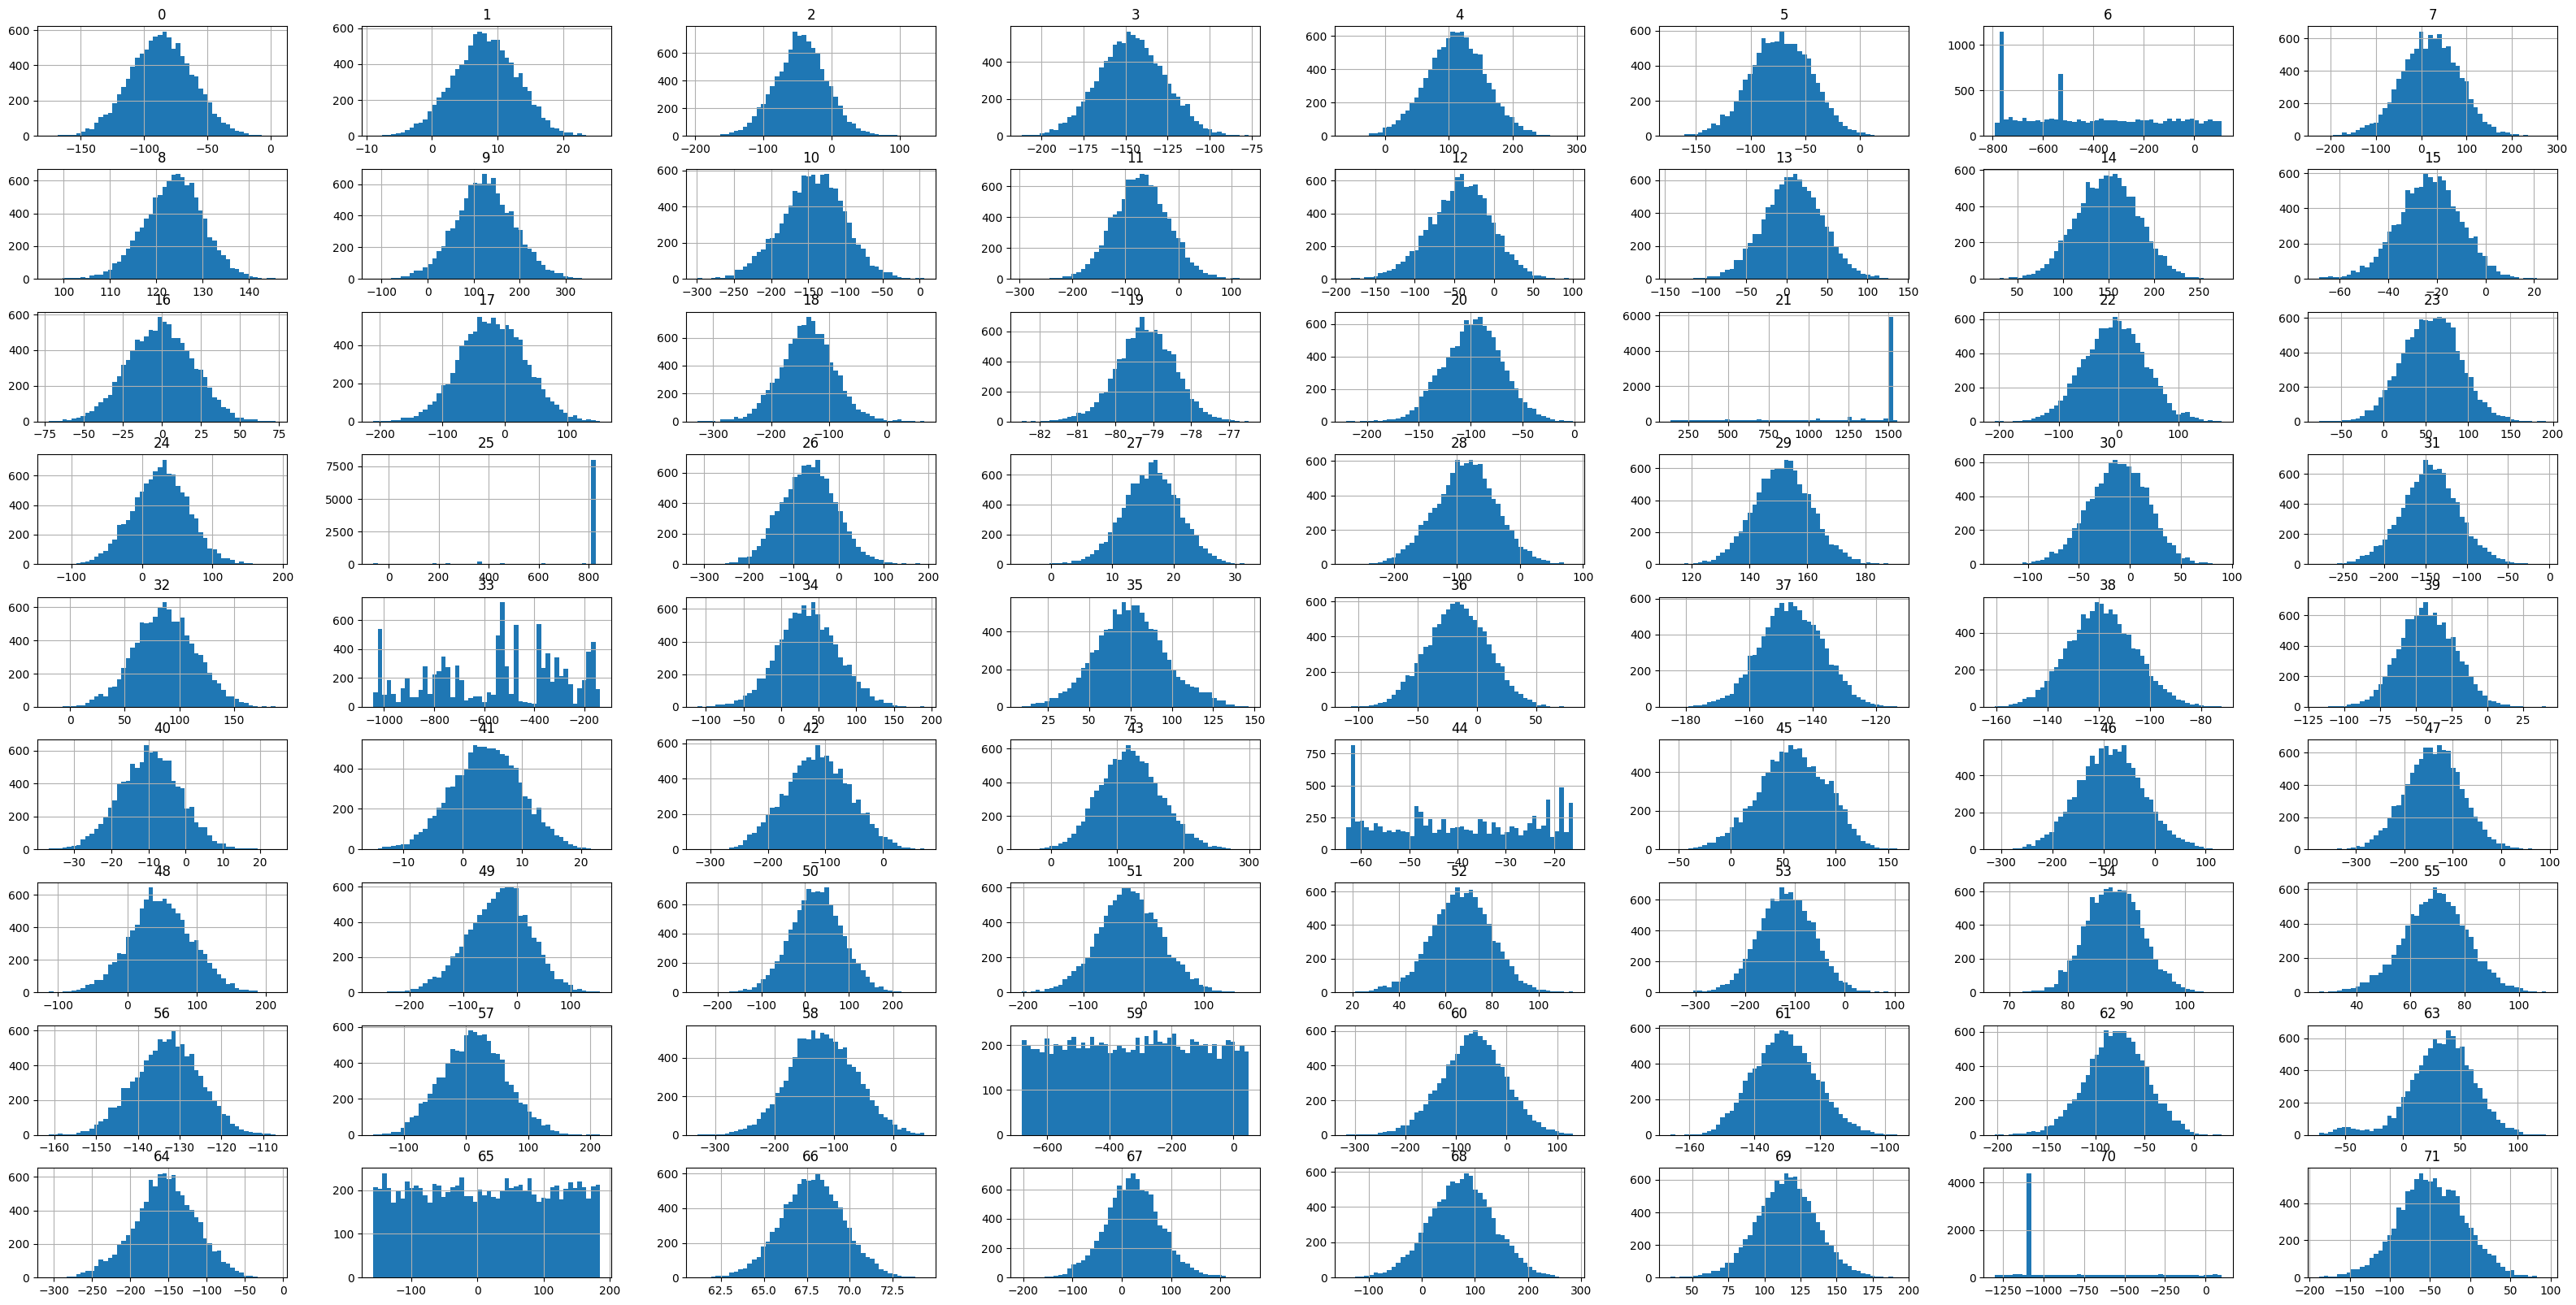

In [31]:
df_samples.hist(figsize=[40, 20], bins=50);

In [32]:
df_samples = df_train[:5000]

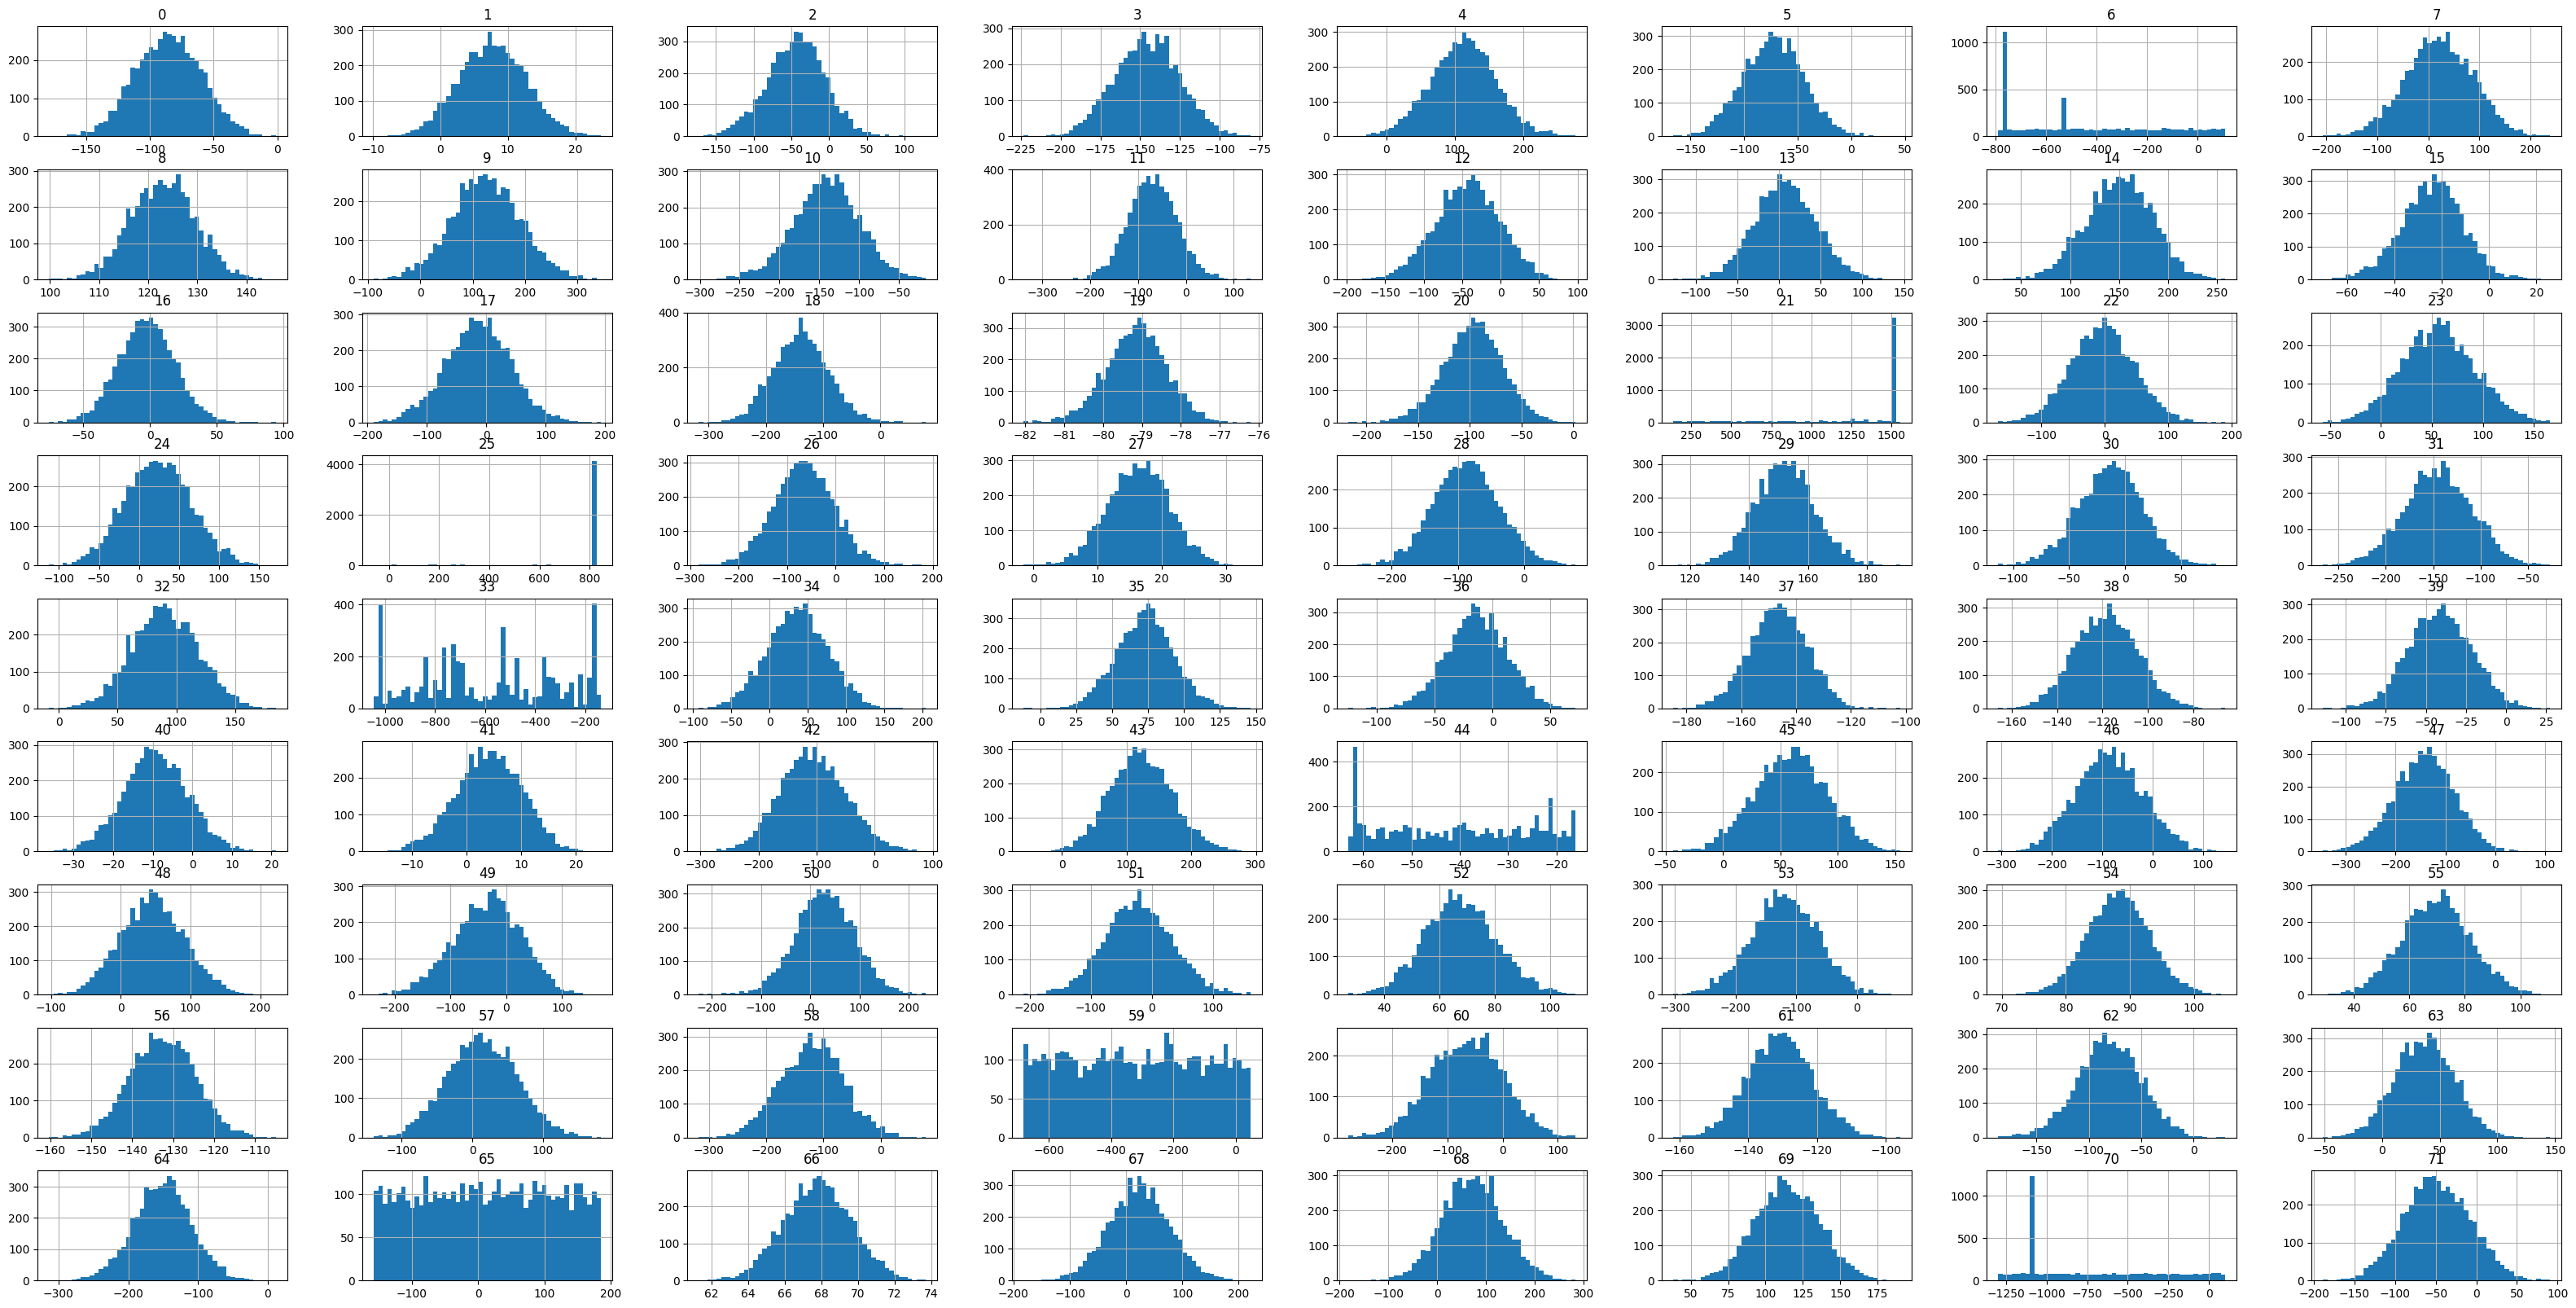

In [33]:
df_samples.hist(figsize=[40, 20], bins=50);

В `df_train` распределения выглядят аналогичным образом. Отметим, что в столбцах '6', '21', '25', '33', '44', '65', '70' распределения признаков значительно отличаются от нормальных.

### Оптимизация данных

Проведём несколько экспериментов, чтобы понять, как отразятся на метрике удаление отдельных признаков, а также различные варианты масштабирования признаков.

In [34]:
scaler_MM = MinMaxScaler()
df_base_MM = scaler_MM.fit_transform(df_base)
df_train_MM = scaler_MM.transform(df_train)

In [35]:
%%time
dims = df_base_MM.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_MM).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_MM).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_MM).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'MinMaxScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 20.33 %
CPU times: user 3min 47s, sys: 3.15 s, total: 3min 50s
Wall time: 2min 35s


In [36]:
del df_base_MM
del df_train_MM

In [37]:
unnormal_columns = ['6', '21', '25', '33', '44', '65', '70']
df_base_drop = df_base.copy()
df_train_drop = df_train.copy()

for df in [df_base_drop, df_train_drop]:
  for column in unnormal_columns:
    df.drop(column, axis=1, inplace=True)

In [38]:
%%time
dims = df_base_drop.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop.values).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'Drop Unnormal')

Кластеры: 1000, nprobe: 10, accuracy@5: 25.903 %
CPU times: user 3min 16s, sys: 1.31 s, total: 3min 17s
Wall time: 2min 1s


In [96]:
important_columns = ['7', '17', '3', '28', '34', '4', '42',
                     '27', '13', '49', '20', '10', '29', '41',
                     '55', '62', '58', '24', '16']
df_base_drop = df_base[important_columns]
df_train_drop = df_train[important_columns]

In [40]:
%%time
dims = df_base_drop.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop.values).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'Drop Unimportant (Catboost)')

Кластеры: 1000, nprobe: 10, accuracy@5: 59.322 %
CPU times: user 1min 26s, sys: 493 ms, total: 1min 27s
Wall time: 53.8 s


In [42]:
scaler_RS = RobustScaler()
df_base_RS = scaler_RS.fit_transform(df_base)
df_train_RS = scaler_RS.transform(df_train)

In [43]:
%%time
dims = df_base_RS.shape[1] #кол-во признаков
#base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_RS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_RS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_RS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'RobustScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 52.55 %
CPU times: user 3min 29s, sys: 2.13 s, total: 3min 31s
Wall time: 2min 8s


In [44]:
del df_base_RS
del df_train_RS

In [97]:
scaler_SS = StandardScaler()
df_base_SS = scaler_SS.fit_transform(df_base)
df_train_SS = scaler_SS.transform(df_train)
scaler_filename = f'/content/drive/MyDrive/std_scale_1.bin'
dump(scaler_SS, scaler_filename, compress=True)

df_base_drop_SS = scaler_SS.fit_transform(df_base_drop)
df_train_drop_SS = scaler_SS.transform(df_train_drop)

In [98]:
del df_base_drop
del df_train_drop

In [49]:
%%time
dims = df_base_SS.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_SS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_SS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 63.748 %
CPU times: user 3min 38s, sys: 1.45 s, total: 3min 39s
Wall time: 2min 19s


In [50]:
%%time
dims = df_base_drop_SS.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop_SS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop_SS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop_SS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, \
                    'StandardScaler, Drop Unimportant')

Кластеры: 1000, nprobe: 10, accuracy@5: 63.282 %
CPU times: user 1min 31s, sys: 483 ms, total: 1min 31s
Wall time: 59.1 s


In [51]:
del df_base_drop_SS
del df_train_drop_SS
# del df_base_SS
# del df_train_SS

### Промежуточные результаты - 2

In [52]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Наилучшие показатели у данных, отмасштабированных с помощью StandardScaler. Будем работать с этими данными дальше.

Вообще такой большой прирост качества "из коробки" намекает, что работой с признаками можно ещё сильнее улучшить метрику.

## Ранжирование (NOT IMPLEMENTED YET)

### Catboost в качестве ранжирующей модели

Соберём большее количество соседей. Для экономии времени была выбрана не самая оптимальная конфигурация.

In [53]:
# здесь подобрать оптимальные параметры для будущего использования

dims = df_base.shape[1] #кол-во признаков
k = 50 #кол-во ближайших соседей
n_cells = 200 #кол-во ячеек в индексе
nprobe = 20 #кол-во кластеров для поиска
index_filename = f'/content/drive/MyDrive/idx_l2_{n_cells}_{nprobe}.index'

Сохраним индекс на диске. В будущем можно будет им пользоваться, не проводя предварительные вычисления.

In [54]:
%%time
if not os.path.exists(index_filename):
  quantizer = faiss.IndexFlatL2(dims)
  idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
  idx_l2.train(np.ascontiguousarray(df_base_SS).astype('float32'))
  idx_l2.add(np.ascontiguousarray(df_base_SS).astype('float32'))
  idx_l2.nprobe = nprobe
  r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS).astype('float32'), k)
  accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler, 50 Neighbours')
  faiss.write_index(idx_l2, index_filename)
else:
  idx_l2 = faiss.read_index(index_filename)

CPU times: user 264 ms, sys: 861 ms, total: 1.12 s
Wall time: 12.3 s


In [55]:
## считаем очень ограниченный объём запроса, для теста
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS[:40]).astype('float32'), 50)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler, 50 Neighbours')

Кластеры: 200, nprobe: 20, accuracy@5: 80.0 %
CPU times: user 666 ms, sys: 5.98 ms, total: 672 ms
Wall time: 363 ms


In [56]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics.tail(1)

,Кластеры,Поиск в соседних,Опции,accuracy@5
16,200,20,"StandardScaler, 50 Neighbours",80.0


In [57]:
len(idx)

40

In [58]:
len(idx[0])

50

In [59]:
targets.head()

Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: Target, dtype: object

In [60]:
columns=df_base.columns.tolist()
all_columns = columns
new_columns = [f'{col}_search' for col in columns]
all_columns.extend(new_columns)

In [61]:
# Далее идет совершенно неправильный способ задания обучающего датафрейма.
df_base_cat = pd.DataFrame(columns=all_columns)

In [62]:
sycle = 0
# Очень медленно. Другим способом пока что не получилось.
for target, el in zip(targets.values.tolist()[:40], idx.tolist()):
  for r in el:
    if target == base_index[r]:
      df_base_cat.loc[sycle] = df_base.loc[base_index[r]]
      df_base_cat.loc[sycle, 'is_neighbour'] = 1
      df_base_cat.loc[sycle, new_columns] = df_train_SS[sycle]
    else:
      df_base_cat.loc[sycle] = df_base.loc[base_index[r]]
      df_base_cat.loc[sycle, 'is_neighbour'] = 0
      df_base_cat.loc[sycle, new_columns] = df_train_SS[sycle]
    df_base_cat.loc[sycle, 'result'] = base_index[r]
    sycle+=1

sycle

2000

In [63]:
df_base_cat = df_base_cat.set_index('result')

In [64]:
df_base_cat.shape

(2000, 145)

In [65]:
# Ещё и в результате запихнул рядом масштабированные и немасштабированные данные

#df_base_cat[columns] = scaler_SS.fit_transform(df_base_cat[columns])

In [66]:
df_base_cat[df_base_cat['is_neighbour']==1].sample()

,0,1,2,3,4,5,6,7,8,9,...,63_search,64_search,65_search,66_search,67_search,68_search,69_search,70_search,71_search,is_neighbour
result,,,,,,,,,,,,,,,,,,,,,
1472602-base,-50.560276,6.85605,-116.298416,-134.443573,65.36528,-127.86235,-775.150146,93.207756,125.221085,269.0495,...,0.494058,0.246555,-1.645563,0.442173,1.717478,1.533163,0.097805,0.409531,-1.845699,1.0


In [67]:
# Очень мало целевого признака
df_base_cat['is_neighbour'].sum()/df_base_cat.shape[0]

0.016

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    df_base_cat.drop(['is_neighbour'] , axis=1),
    df_base_cat['is_neighbour'],
    test_size=0.25,
    random_state=2007,
    stratify=df_base_cat['is_neighbour']
    )

In [69]:
cat_features = []

In [70]:
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

In [71]:
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [72]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          #'learning_rate': 0.01,
          'random_seed': 2007,
          'verbose':100
          }

In [73]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    #early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.6408783784
bestIteration = 1

Training on fold [1/5]

bestTest = 0.6291525424
bestIteration = 30

Training on fold [2/5]

bestTest = 0.5196610169
bestIteration = 0

Training on fold [3/5]

bestTest = 0.7640677966
bestIteration = 23

Training on fold [4/5]

bestTest = 0.836440678
bestIteration = 32



In [74]:
model = CatBoostClassifier(**params)

In [75]:
model.fit(train_data)

Learning rate set to 0.01225
0:	total: 48.3ms	remaining: 48.2s
100:	total: 3.71s	remaining: 33.1s
200:	total: 9.38s	remaining: 37.3s
300:	total: 13s	remaining: 30.2s
400:	total: 16.7s	remaining: 24.9s
500:	total: 22.2s	remaining: 22.1s
600:	total: 25.9s	remaining: 17.2s
700:	total: 29.5s	remaining: 12.6s
800:	total: 33.5s	remaining: 8.32s
900:	total: 38.7s	remaining: 4.25s
999:	total: 42.2s	remaining: 0us


In [76]:
# может быть это будет полезно для оптимизации поиска. проверено.
model.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,7_search,3.808227
1,17,2.604191
2,3_search,1.976742
3,28,1.938884
4,34_search,1.839677
5,4_search,1.802943
6,42_search,1.528511
7,27_search,1.522031
8,13_search,1.435892
9,49_search,1.304038


In [77]:
# Сохраним модель для будущего использования
model_filename = f'/content/drive/MyDrive/cbm_1.cbm'
model.save_model(model_filename,
           format="cbm",
           export_parameters=None,
           pool=None)

In [78]:
y_pr = model.predict_proba(test_data)[:, 1]
#np.argsort(y_pr)

In [79]:
X_test['is_neighbour'] = y_test
X_test['is_neighbour_proba'] = y_pr
roc_auc_score(X_test['is_neighbour'],X_test['is_neighbour_proba'])

0.4994918699186992

Модель требует дополнительной настройки и в данном виде неприменима для улучшения метрики.

### Промежуточные результаты - 3

In [80]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Как показывает тестирование, модель в состоянии указать на наиболее важные признаки, которым можно будет уделять дополнительное внимание.

## Решение задачи

Загрузим сохранённый ранее индекс и проведём поиск 5 ближайших соседей для всех товаров из `validation.csv`.

In [81]:
idx_l2 = faiss.read_index('/content/drive/MyDrive/idx_l2_200_20.index')
nprobe = idx_l2.nprobe

In [99]:
# ответы у нас уже есть
answers = df_validation_answer.squeeze()
# не забываем масштабирование
scaler_SS=load(scaler_filename)
df_validation_SS = scaler_SS.transform(df_validation)

In [86]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_validation_SS).astype('float32'), 5)
accuracy_aggregator(answers, idx, base_index, 200, nprobe, 'Validation')

Кластеры: 200, nprobe: 20, accuracy@5: 64.801 %
CPU times: user 25min 50s, sys: 2.45 s, total: 25min 53s
Wall time: 16min 45s


In [92]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics.tail(1)

,Кластеры,Поиск в соседних,Опции,accuracy@5
17,200,20,Validation,64.801


## Выводы

В проекте решалась **задача разработки алгоритма, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`**.

При этом:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

Для подбора оптимальных параметров приближенного поиска использовался обучающий датасет `target.csv`. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).

- При решении задачи была использована библиотека для приближённого поиска ближайших соседей `FAISS`.

- Проведён исследовательский анализ данных. В целях повышения метрики произведено масштабирование признаков с использованием `StandardScaler`.

- Создан, обучен и сохранён на диск индекс для `FAISS` с оптимальными в рамках данного исследования параметрами.

- В качестве демонстрации подхода обучена ранжирующая модель CatBoost. В дальнейшем модель позволит дополнительно оптимизировать поиск, а также выделить наиболее значимые признаки.

- Время поиска 5 ближайших соседей для датасета `validation.csv` на этом индексе составило около **15 минут** (Colab, без подписки).

- Качество предложенного алгоритма по метрике `accuracy@5` для датасета `validation.csv` составило **64,8%**.

- Сохранённые индекс и модель позволяют реализовать развёртывание решения в виде микросервиса.
